In [1]:
import os
import sys
import copy
from pprint import pprint
import wandb
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.models import CHNN
from src.systems.chain_pendulum import ChainPendulum
from src.train.ensemble_trainer import DeepEnsembleTrainer

sns.set_theme()
sns.set_context('paper')

%matplotlib inline
%load_ext autoreload
%autoreload 2

dump_dir = os.path.abspath('../.log')

In [2]:
def parse_dump(dump):
    ts = dump.get('ts')
#     z0_orig = dump.get('z0_orig')
    true_zt = dump.get('true_zt')
#     true_zt_chaos = dump.get('true_zt_chaos')
    pred_zt = dump.get('pred_zt')

    return ts, true_zt, pred_zt

def download_runs_sweep(run_ids):
    api = wandb.Api()
    for run_id in run_ids:
        download_root = os.path.join(dump_dir, run_id)
        run = api.run("ngruver/physics-uncertainty-exps/{}".format(run_id))
        
        for f in run.files():
            if f.name != 'data.pt' and f.name != 'model.pt':
                continue
        
            fpath = os.path.join(download_root, f.name)
            if not os.path.isfile(fpath):
                f.download(root=download_root)
                
            if f.name == 'data.pt':
                data = torch.load(fpath)
            else:
                model = torch.load(fpath, map_location=torch.device('cpu'))
            
        yield run.name, run.config, model, parse_dump(data)

de_run_id = ["1axj7lqk"]

for _, cfg, model_dict, (ts, true_zt, pred_zt) in download_runs_sweep(de_run_id):
    pass

cfg.pop('uq_type')

body = ChainPendulum(cfg.get('num_bodies', 3))
trainer = DeepEnsembleTrainer(**cfg, network=CHNN, body=body)

# ensemble_dict = {k[k.find(".") + 1:]: model_dict[k] for k in model_dict if k.startswith("ensemble")}
trainer.model.load_state_dict(model_dict)

<All keys matched successfully>

In [3]:
preds = trainer.model(true_zt[:,0].to("cuda"), ts.to("cuda"))

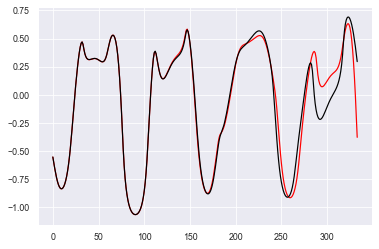

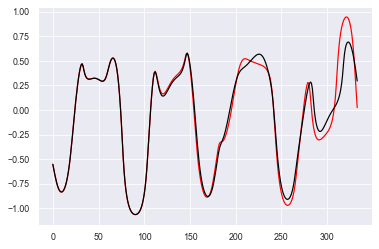

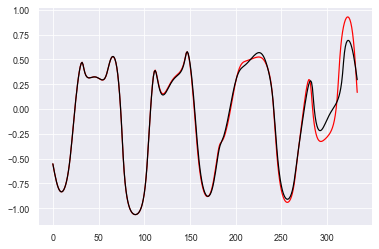

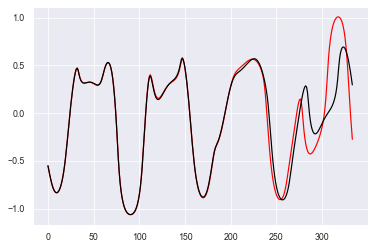

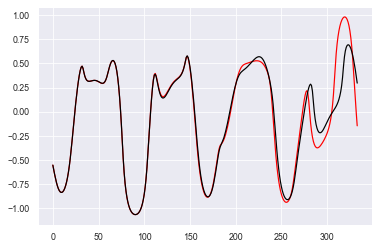

In [4]:
preds = preds.cpu().detach()

num_models, num_init, T = preds.shape[:3]
for i in range(1):
    for j in range(num_models):
        y_pred = preds[j, i, :, 0, 0, 0]
        y_gt = true_zt[i, :, 0, 0, 0]
        plt.plot(range(T), y_pred, color='red')
        plt.plot(range(T), y_gt, color='black')
        plt.show()
        plt.close()

In [5]:
n_samples = 5
z0 = true_zt[:,0]
z0_dup = z0.unsqueeze(0).expand(n_samples, -1, -1, -1, -1)
eps = 2. * torch.rand_like(z0_dup) - 1.
perturbed_z0 = z0_dup + 1e-3 * eps
perturbed_z0 = project_onto_constraints(body.body_graph, perturbed_z0, tol=1e-5)

model0 = trainer.model.ensemble[0]
batched_z0 = perturbed_z0.reshape(n_samples * z0.shape[0], *z0.shape[1:])
preds = model0.integrate(batched_z0.to("cuda"), ts.to("cuda"), method='rk4')
print(preds.size())

torch.Size([125, 334, 2, 3, 2])


In [13]:
def compute_rel_error(ref, pred):
    '''
    N is the number of initial conditions.
    M is the number of samples in prediction
    The first dimension "2" corresponds to position + velocity.
    B is the number of bodies.
    The last dimension "2" corresponds to xy.

    Arguments:
        ref: N x T x 2 x B x 2
        pred: M x N x T x 2 x B x 2
    '''
    delta_z = ref.unsqueeze(0) - pred  # M x N x T x 2 x B x 2
    all_err = delta_z.pow(2).sum(dim=-1).sum(dim=-1).sum(dim=-1).sqrt()  # M x N x T

    sum_z = ref.unsqueeze(0) + pred  # M x N x T x 2 x B x 2
    pred_rel_err = all_err / sum_z.pow(2).sum(dim=-1).sum(dim=-1).sum(dim=-1).sqrt()  # M x N x T

    return pred_rel_err

def compute_geom_mean(ts, values):
    '''Geometric mean of a continuous function over time.
    Arguments:
        ts: T
        values: ... x T
    '''
    t_range = ts.max() - ts.min()
    return torch.trapz((values + 1e-8).log(), ts).div(t_range).exp()  # ...

In [20]:
for i in range(preds.size(0)):
    rel_err = compute_rel_error(true_zt, pred_zt[i])
    err_geom_mean = compute_geom_mean(ts, rel_err)
    print("Model {}".format(i))
    print(err_geom_mean.mean())
    print(err_geom_mean.std())
    print("")
    
rel_err = compute_rel_error(true_zt, pred_zt.mean(0))
err_geom_mean = compute_geom_mean(ts, rel_err)
print("Ensembled")
print(err_geom_mean.mean())
print(err_geom_mean.std())

Model 0
tensor(0.1568)
tensor(0.2347)

Model 1
tensor(0.1431)
tensor(0.2132)

Model 2
tensor(0.1502)
tensor(0.2117)

Model 3
tensor(0.1680)
tensor(0.2308)

Model 4
tensor(0.1469)
tensor(0.1934)

Ensembled
tensor(0.1420)
tensor(0.2126)


In [9]:
preds = preds.reshape(n_samples, *true_zt.shape).cpu().detach()
preds.size()

torch.Size([5, 25, 334, 2, 3, 2])

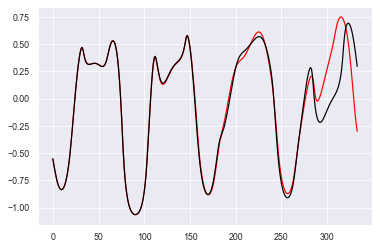

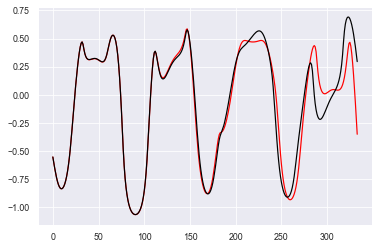

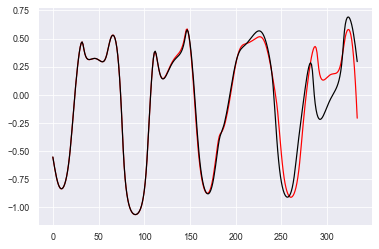

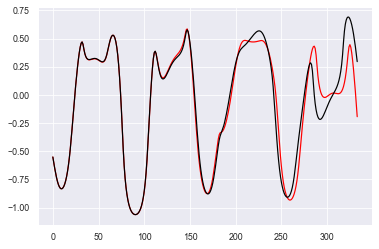

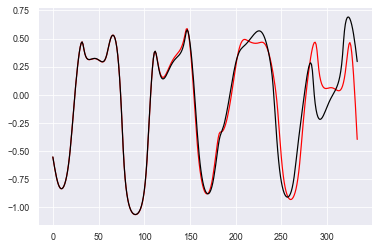

In [10]:
num_models, num_init, T = preds.shape[:3]
for i in range(1):
    for j in range(num_models):
        y_pred = preds[j, i, :, 0, 0, 0]
        y_gt = true_zt[i, :, 0, 0, 0]
        plt.plot(range(T), y_pred, color='red')
        plt.plot(range(T), y_gt, color='black')
        plt.show()
        plt.close()

In [ ]:
def compute_rel_error(ref, pred):
    '''
    N is the number of initial conditions.
    M is the number of samples in prediction
    The first dimension "2" corresponds to position + velocity.
    B is the number of bodies.
    The last dimension "2" corresponds to xy.

    Arguments:
        ref: N x T x 2 x B x 2
        pred: M x N x T x 2 x B x 2
    '''
    delta_z = ref.unsqueeze(0) - pred  # M x N x T x 2 x B x 2
    all_err = delta_z.pow(2).sum(dim=-1).sum(dim=-1).sum(dim=-1).sqrt()  # M x N x T

    sum_z = ref.unsqueeze(0) + pred  # M x N x T x 2 x B x 2
    pred_rel_err = all_err / sum_z.pow(2).sum(dim=-1).sum(dim=-1).sum(dim=-1).sqrt()  # M x N x T

    return pred_rel_err

def compute_geom_mean(ts, values):
    '''Geometric mean of a continuous function over time.
    Arguments:
        ts: T
        values: ... x T
    '''
    t_range = ts.max() - ts.min()
    return torch.trapz((values + 1e-8).log(), ts).div(t_range).exp()  # ...

In [19]:
for i in range(preds.size(0)):
    rel_err = compute_rel_error(true_zt, preds[i])
    err_geom_mean = compute_geom_mean(ts, rel_err)
    print("Model {}".format(i))
    print(err_geom_mean.mean())
    print(err_geom_mean.std())
    print("")
    
rel_err = compute_rel_error(true_zt, preds.mean(0))
err_geom_mean = compute_geom_mean(ts, rel_err)
print("Ensembled")
print(err_geom_mean.mean())
print(err_geom_mean.std())

Model 0
tensor(0.1688)
tensor(0.2579)

Model 1
tensor(0.1656)
tensor(0.2303)

Model 2
tensor(0.1616)
tensor(0.2342)

Model 3
tensor(0.1687)
tensor(0.2426)

Model 4
tensor(0.1640)
tensor(0.2506)

tensor(0.1596)
tensor(0.2433)


In [ ]:
#do perturbed dynamics models
# make wrapper class around self.dynamics that adds noise to output

#